### Deep Learning for Maintenance & Manufacturing Department
This project to apply Deep Learning (Residual Network / RESNET) to detect and locate defects (image segmentation) using imagery data (Length Encoding) which could significantly improve the production efficiency in the manufacturing industry. 

In [656]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
%matplotlib inline

In [657]:
defect_class_mask_df = pd.read_csv('train.csv')
defect_class_mask_df.head(4)

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...


In [449]:
all_images_df = pd.read_csv('defect_and_no_defect.csv')
all_images_df.head(4)

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1


### Visualize and explore dataset

In [450]:
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)
defect_class_mask_df.head(4)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1


C:\Users\Sealion\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of images per class')

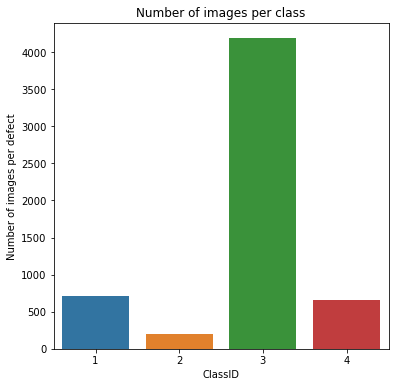

In [451]:
plt.figure(figsize=(6,6))
sns.countplot(defect_class_mask_df['ClassId'])
plt.ylabel('Number of images per defect')
plt.xlabel('ClassID')
plt.title('Number of images per class')

In [452]:
# Some images are classified with more than one defect.
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

In [453]:
defect_type.value_counts()

1    5201
2     272
3       1
Name: mask, dtype: int64

Text(0.5, 1.0, 'Number of defects in image')

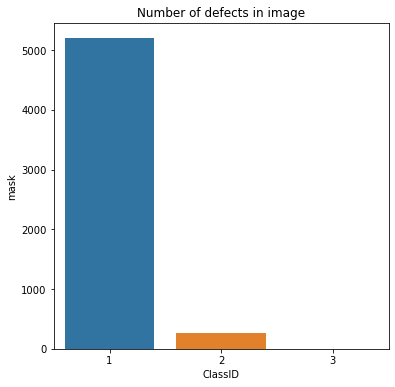

In [454]:
plt.figure(figsize=(6,6))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts() )
plt.xlabel('ClassID')
plt.title('Number of defects in image')

In [455]:
defect_class_mask_df.shape, all_images_df.shape

((5748, 4), (12997, 2))

In [456]:
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defect and non-defect images')

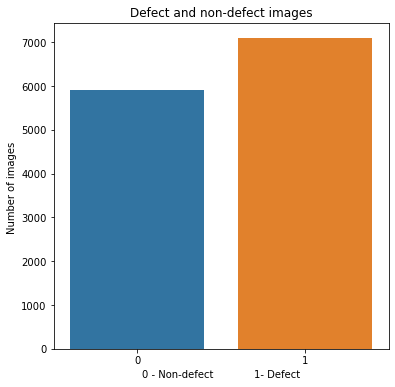

In [457]:
plt.figure(figsize=(6,6))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts() )
plt.ylabel('Number of images ')
plt.xlabel('0 - Non-defect   1- Defect')
plt.title('Defect and non-defect images')

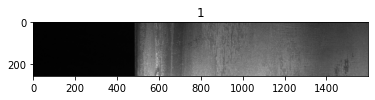

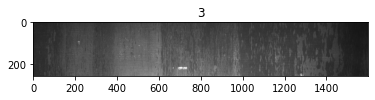

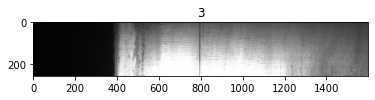

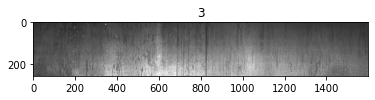

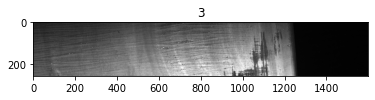

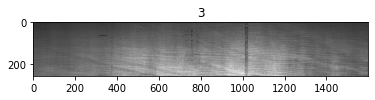

In [458]:
train_dir = 'train_images/'
for i in range(6):
  # Specify the path to the images given their image ID
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  plt.figure()
  plt.title(defect_class_mask_df.ClassId[i])
  plt.imshow(img)

In [459]:
defect_class_mask_df.head(4)

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1


In [467]:
#function to convert rle to mask (RLE: Run length Encoding)
def rle2mask(rle, height, width):  
    #creating a one dimentional array containing 0's of length obtained by multiplying height and width of the image
    mask = np.zeros(height*width).astype(np.uint8)
    #spliting the rle based on space , try running the rle.split() on separate cell to see how the values are separated based on space
    rle = rle.split()
    #selecting every second value in the list like obtaining values corresponding to indexes 0,2,4,....
    start = rle[0::2]
    #selecting every second value in the list like obtaining values corresponding to indexes 1,3,5,....
    length = rle[1::2]  
    for i in range(len(start)):
        mask[int(start[i]):(int(start[i])+int(length[i]))] = 1

    #Now the shape of the mask is in one dimension, we need to convert the mask to the same dimension as the image, initally using reshape and followed by Transpose
    img = mask.reshape(width, height)
    img = img.T
    return img

In [468]:
#Function to convert mask to rle
def mask2rle(mask):
    #We do the reverse of what we did in the above function, initially apply Transpose to the mask image and then flatten to one dimension
    pixels = mask.T.flatten()
    #Here, we add extra values at front and end , this would help in finding the correct length of pixels that have been masked
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0]

    #here we subtract values in even index in the obtained list(i.e) [2,5], from the odd index, (i.e.)5-2 = 3, Now the list would look like [2, 3]
    rle[1::2] -= rle[0::2]
    #finally join to rle format, in this case it would look like ('2 3')
    return ' '.join(str(x) for x in rle)

In [570]:
# Let's try to use the rle2mask on a sample image 
from utilities import rle2mask , mask2rle
image_index = 20 #20 30
mask = rle2mask(defect_class_mask_df.EncodedPixels[image_index], img.shape[0], img.shape[1])
mask.shape

(256, 1600)

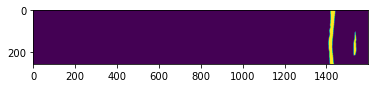

In [470]:
# Let's show the mask
plt.imshow(mask)

(256, 1600, 3)

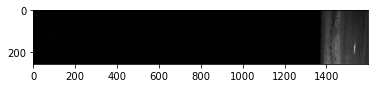

In [471]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[image_index]))
plt.imshow(img)
img.shape

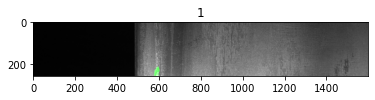

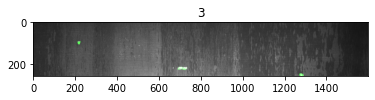

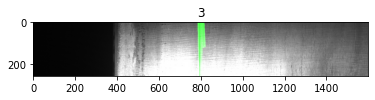

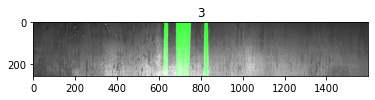

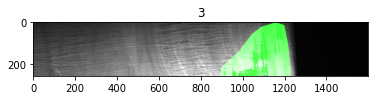

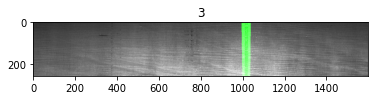

In [472]:
for i in range(6):
  # Read the images using opencv and converting to rgb format
  img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Get the mask for the image from rle
  mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
  
  # Let's color the pixels with values = 1 
  img[mask == 1,1] = 255
  plt.figure()
  plt.imshow(img)
  plt.title(defect_class_mask_df.ClassId[i])

### Train deep learning model to detect whether defect or not.

In [473]:
# split the data (defective and non defective) into training and testing 
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size=0.15)
train.shape, test.shape

((11047, 2), (1950, 2))

In [474]:
# create a image generator for the training and validation dataset
# we will divide the data to training, validation and testing
# Training = 9390, validation = 1657, testing = 1950 

from keras_preprocessing.image import ImageDataGenerator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
train_generator = datagen.flow_from_dataframe(
                    dataframe = train,
                    directory = train_dir,
                    x_col = "ImageID",
                    y_col = "label",
                    subset = "training",
                    batch_size = 16,
                    shuffle = True,
                    class_mode = "other",
                    target_size = (256, 256))


valid_generator = datagen.flow_from_dataframe(
                    dataframe = train,
                    directory = train_dir,
                    x_col = "ImageID",
                    y_col = "label",
                    subset = "validation",
                    batch_size = 16,
                    shuffle = True,
                    class_mode = "other",
                    target_size = (256, 256))

Found 9390 validated image filenames.
Found 1657 validated image filenames.


In [475]:
# Create a data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
                dataframe = test,
                directory = train_dir,
                x_col = "ImageID",
                y_col = None,
                batch_size = 16,
                shuffle = False,
                class_mode = None,
                target_size = (256, 256))

Found 1950 validated image filenames.


In [23]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
# freeze the model weights (transfer learning)
for layer in basemodel.layers:
  layers.trainable = False

In [25]:
# Customerized model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)
model = Model(inputs = basemodel.input, outputs = headmodel)
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [27]:
# Use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="resnet-weights.hdf5", verbose=1, save_best_only=True)
# (WARNING TAKES LONG TIME!)
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 40, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
586/586 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.7200
Epoch 00001: val_loss improved from inf to 0.69395, saving model to resnet-weights.hdf5
586/586 [==============================] - 145s 247ms/step - loss: 0.5961 - accuracy: 0.7200 - val_loss: 0.6939 - val_accuracy: 0.5437
Epoch 2/40
586/586 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.7948
Epoch 00002: val_loss did not improve from 0.69395
586/586 [==============================] - 138s 235ms/step - loss: 0.4274 - accuracy: 0.7948 - val_loss: 1.1895 - val_accuracy: 0.7021
Epoch 3/40
586/586 [==============================] - ETA: 0s - loss: 0.3799 - accuracy: 0.8247
Epoch 00003: val_loss improved from 0.69395 to 0.52533, saving model to resnet-weights.hdf5
586/586 [==============================] - 139s 238ms/step - loss: 0.3799 - accuracy: 0.8247 - val_loss: 0.5253 - val_accuracy: 0.8089


586/586 [==============================] - ETA: 0s - loss: 0.0533 - accuracy: 0.9814
Epoch 00028: val_loss did not improve from 0.22019
586/586 [==============================] - 138s 235ms/step - loss: 0.0533 - accuracy: 0.9814 - val_loss: 0.4018 - val_accuracy: 0.8920
Epoch 29/40
586/586 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9821
Epoch 00029: val_loss did not improve from 0.22019
586/586 [==============================] - 210s 358ms/step - loss: 0.0516 - accuracy: 0.9821 - val_loss: 5.2734 - val_accuracy: 0.5734
Epoch 30/40
586/586 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9806
Epoch 00030: val_loss did not improve from 0.22019
586/586 [==============================] - 141s 240ms/step - loss: 0.0538 - accuracy: 0.9806 - val_loss: 1.5637 - val_accuracy: 0.7573
Epoch 31/40
586/586 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9827
Epoch 00031: val_loss did not improve from 0.22019
586/586 [======

In [606]:
# save the trained model architecture for future use
model_json = model.to_json()
with open("resnet-classifier-model.json","w") as json_file:
  json_file.write(model_json)

### ASSESS TRAINED MODEL PERFORMANCE

In [607]:
with open('resnet-classifier-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer='Nadam', metrics= ["accuracy"])

In [608]:
# Make prediction (WARNING TAKES LONG TIME (~10 mins)!)
from keras_preprocessing.image import ImageDataGenerator
test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

121/121 [==============================] - 17s 140ms/step


In [609]:
test_predict

array([[6.1059110e-03],
       [9.9998653e-01],
       [9.9970430e-01],
       ...,
       [9.9896622e-01],
       [5.6611050e-16],
       [4.1988122e-04]], dtype=float32)

In [34]:
# Since we have used sigmoid activation at the end, our result would contain continuous values from 0 to 1.
# The network is initially used to classify whether the image has defect or not
# Then these images (defective) is passed through the segmentation network to get the localization and type of defect. 
# Let's choose 0.01, to make sure, that we omit images from passing through the segmentation network only we are highly certain 
# that it has no defect and if we are not confident, we can pass this image through the segmentation network

predict = []
for i in test_predict:
  if i < 0.01: #0.5
    predict.append(0)
  else:
    predict.append(1)
predict = np.asarray(predict)
original = np.asarray(test.label)[:1936]
print(len(predict), len(original))

1936 1936


In [35]:
# Find the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(original, predict)
accuracy

0.8755165289256198

<AxesSubplot:>

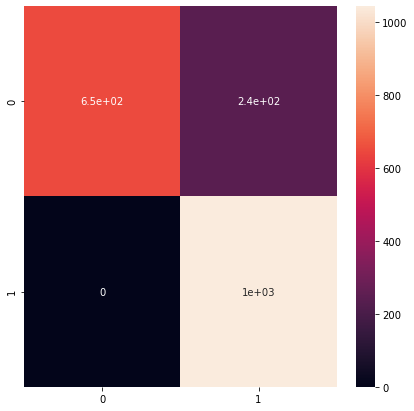

In [36]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

In [37]:
# Print the classification report
from sklearn.metrics import classification_report
report = classification_report(original,predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       892
           1       0.81      1.00      0.90      1044

    accuracy                           0.88      1936
   macro avg       0.91      0.86      0.87      1936
weighted avg       0.90      0.88      0.87      1936



### Build a RESUNET segmentation model.

ResUNet architecture combines UNet backbone architecture with residual blocks to overcome the vanishing gradients problems present in deep architectures.

Unet architecture is based on Fully Convolutional Networks and modified in a way that it performs well on setgmentation tasks.

Resunet consists of three parts:
(1). Encoder or contracting path
(2). Bottleneck
(3). Decoder or expansive path


In [610]:
#spliting the data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(defect_class_mask_df, test_size=0.2)

#creating separate list for imageId, classId and rle to pass into the generator
train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)
val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [611]:
#creating image generators
from utilities import DataGenerator
training_generator = DataGenerator(train_ids,train_class, train_rle, train_dir)
validation_generator = DataGenerator(val_ids,val_class,val_rle, train_dir)

In [617]:
def resblock(X, f): 
    # making a copy of input
    X_copy = X
    # main path. Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
    X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    # Short path. Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    # Adding the output from main path and short path together
    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [618]:
# function to upscale and concatnating the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

In [619]:
input_shape = (256,256,1)

#Input tensor shape
X_input = Input(input_shape)
#Stage 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5
conv5_in = resblock(pool_4, 256)

#Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Final Output
output = Conv2D(4, (1,1), padding = "same", activation = "sigmoid")(up_4)
model_seg = Model(inputs = X_input, outputs = output )

In [638]:
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [640]:
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="resunet-segmentation-weights.hdf5", verbose=1, save_best_only=True)

history = model_seg.fit_generator(training_generator, epochs = 40, validation_data= validation_generator, callbacks=[checkpointer, earlystopping])

In [642]:
# Save model
model_json = model_seg.to_json()
with open("resunet-segmentation-model.json","w") as json_file:
  json_file.write(model_json)

In [643]:
from utilities import focal_tversky, tversky_loss, tversky
with open('resunet-segmentation-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model  
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [645]:
test_df = pd.read_csv('test.csv')
test_df.head(4)

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...


In [646]:
test_df.ImageId

0      0ca915b9f.jpg
1      7773445b7.jpg
2      5e0744d4b.jpg
3      6ccde604d.jpg
4      16aabaf79.jpg
           ...      
633    a4334d7da.jpg
634    418e47222.jpg
635    817a545aa.jpg
636    caad490a5.jpg
637    a5e9195b6.jpg
Name: ImageId, Length: 638, dtype: object

In [647]:
from utilities import prediction
# make prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [648]:
# create a dataframe for the result
df_pred= pd.DataFrame({'ImageId': image_id,'EncodedPixels': mask,'ClassId': defect_type})
df_pred.head()

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3


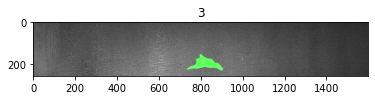

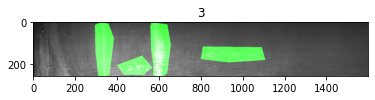

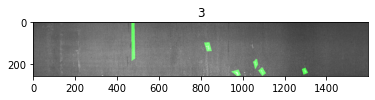

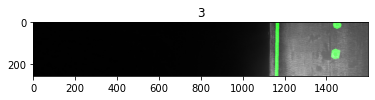

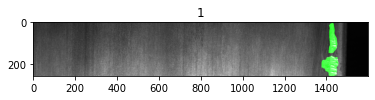

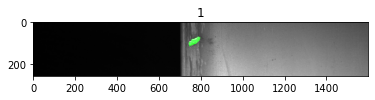

In [653]:
# Let's show the images along with their original (ground truth) masks
for i in range(6):
  # read the images using opencv and convert them to rgb format
  img = io.imread(os.path.join(train_dir,test_df.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # Obtain mask for the image from rle
  mask = rle2mask(test_df.EncodedPixels[i],img.shape[0],img.shape[1])

  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df.ClassId[i])
  plt.imshow(img)

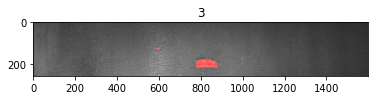

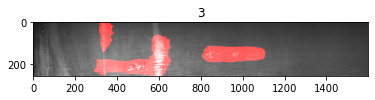

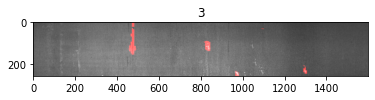

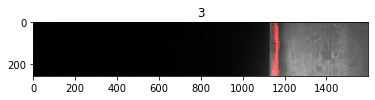

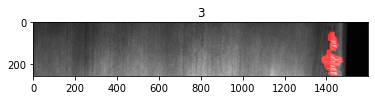

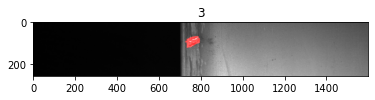

In [654]:
# visualize the results (model predictions)
directory = "train_images"
for i in range(6):
  # read the images using opencv and convert to rgb format
  img = io.imread(os.path.join(directory,df_pred.ImageId[i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # get the mask for the image from rle
  mask = rle2mask(df_pred.EncodedPixels[i],img.shape[0],img.shape[1])  
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred.ClassId[i])
  plt.imshow(img)